# Business Understanding

   Neural networks, particularly convolutional neural networks (CNNs), have revolutionized the field of medical image analysis due to their ability to learn complex patterns in data. In the context of diagnosing pneumonia from X-ray scans, CNNs can be trained on large datasets of chest X-rays that have been labeled as showing signs of pneumonia or not. These networks learn to identify the subtle features and patterns that differentiate pneumonia-infected lungs from healthy ones. For instance, they can detect the presence of opacities or consolidation in the lungs, which are signs of pneumonia. This capability is especially valuable because pneumonia can present with a wide variety of ways, making it challenging for even experienced radiologists to diagnose accurately. By providing consistent and quick assessments, neural networks can assist healthcare professionals in making more accurate diagnoses, potentially leading to earlier and more effective treatment for patients.
    
   Additionally, neural networks can help mitigate the shortage of expert radiologists, especially in under-resourced or rural areas. By integrating neural network-based diagnostic systems into the clinical workflow, hospitals can ensure that every X-ray is analyzed with a level of detail and accuracy that matches that of a specialist. This not only helps in preliminary assessment of cases and prioritizing those that require urgent attention but also serves as a second opinion to reduce the likelihood of misdiagnosis. These systems can be continuously improved as they learn from new data, leading to even better performance over time. The use of neural networks for pneumonia diagnosis via X-ray scans is a prime example of how AI can enhance healthcare delivery and patient outcomes. In this project, we will be attempting to create a model that can accurately predict the diagnoses based on the images presented.

# Data Understanding

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Data Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
#import necessary libraries
import keras
from keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.applications import ResNet50, ResNet152V2, DenseNet121
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from PIL import Image 
import os, shutil
from tensorflow.keras.preprocessing import image

C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#defining folder variables
train_folder = 'data/chest_xray/test'
test_folder = 'data/chest_xray/train'
val_folder =  'data/chest_xray/val'

In [3]:
#defining folder variables
train_normal = 'data/chest_xray/train/NORMAL/'
train_pneumonia = 'data/chest_xray/train/PNEUMONIA/'

test_normal = 'data/chest_xray/test/NORMAL/'
test_pneumonia = 'data/chest_xray/test/PNEUMONIA/'

val_normal = 'data/chest_xray/val/NORMAL/'
val_pneumonia = 'data/chest_xray/val/PNEUMONIA/'

In [4]:
#counting how many images there are in each folder
imgs_pneumonia = [file for file in os.listdir(train_pneumonia) if file.endswith('.jpeg')]

print('There are', len(imgs_pneumonia), 'pneumonia images')

There are 3875 pneumonia images


In [5]:
imgs_normal = [file for file in os.listdir(train_normal) if file.endswith('.jpeg')]

print('There are', len(imgs_normal), 'normal images')

There are 1341 normal images


In [6]:
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')

There are 3876 pneumonia images in the training set


In [7]:
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 9 pneumonia images in the validation set


In [8]:
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')

There are 390 pneumonia images in the test set


In [9]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')

There are 1342 normal images in the training set


In [10]:
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')

There are 234 normal images in the test set


In [11]:
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')

There are 9 normal images in the validation set


In [12]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [13]:
#defining variables to randomly select 5 images for viewing
normal_images = [img for img in os.listdir(f'{train_normal}')]
pneumonia_images = [img for img in os.listdir(f'{train_pneumonia}')]

In [14]:
#randomly selecting 5 images from the folders
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

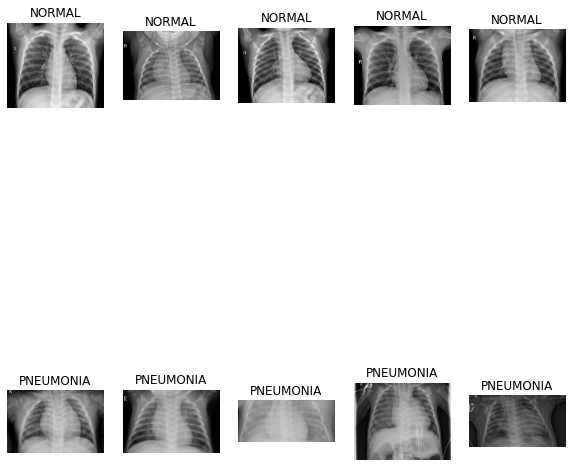

In [15]:
#plotting the random images
fig = plt.figure(figsize=(10,12))
for i in range(10):
    if i<5:
        fpath = f'{train_normal}/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_pneumonia}/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2,5,i+1)
    
    im = image.load_img(fpath)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()

# Data Preparation

In [16]:
#normalizing and resizing images
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=5216)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
#defining the images and labels to prep for model
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [18]:
#counting the number of images and getting the shape of the images
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 624
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (624, 64, 64, 3)
train_labels shape: (624, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 3)
val_labels shape: (16, 2)


In [19]:
#reshaping the images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(624, 12288)
(624, 12288)
(16, 12288)


In [20]:
#reshaping the images
train_y = np.reshape(train_labels[:,0], (624,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

## Baseline Models

In [21]:
#building a baseline model
from keras import models
from keras import layers

np.random.seed(123)
baseline1_model = models.Sequential()
baseline1_model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
baseline1_model.add(layers.Dense(7, activation='relu'))
baseline1_model.add(layers.Dense(5, activation='relu'))
baseline1_model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
#compiling the model
baseline1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline_history = baseline1_model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6428 - accuracy: 0.6282 - val_loss: 0.8769 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6186 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6250 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6571 - val_loss: 0.8277 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.6875 - val_loss: 0.7846 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.6987 - val_loss: 0.7529 - val_accuracy: 0.5000
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4722 - accuracy: 0.7788 - val_loss: 0.6184 - val_accuracy: 0.6250
Epoch 8/50
20/20 [=

In [23]:
results_train = baseline1_model.evaluate(train_img, train_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.8782


In [24]:
results_test = baseline1_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.4095 - accuracy: 0.8301


In [25]:
results_train

[0.2801087498664856, 0.8782051205635071]

In [26]:
results_test

[0.4094952642917633, 0.8301281929016113]

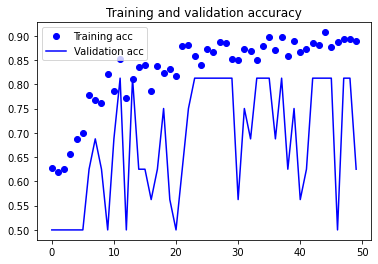

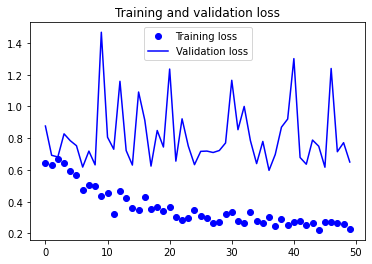

In [27]:
acc_base1 = baseline_history.history['accuracy']
val_acc_base1 = baseline_history.history['val_accuracy']
loss_base1 = baseline_history.history['loss']
val_loss_base1 = baseline_history.history['val_loss']
epochs_base1 = range(len(acc_base1))
plt.plot(epochs_base1, acc_base1, 'bo', label='Training acc')
plt.plot(epochs_base1, val_acc_base1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_base1, loss_base1, 'bo', label='Training loss')
plt.plot(epochs_base1, val_loss_base1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
#building a CNN
np.random.seed(222)
baseline2_model = models.Sequential()
baseline2_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
baseline2_model.add(layers.MaxPooling2D((2, 2)))

baseline2_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
baseline2_model.add(layers.MaxPooling2D((2, 2)))

baseline2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
baseline2_model.add(layers.MaxPooling2D((2, 2)))

baseline2_model.add(layers.Flatten())
baseline2_model.add(layers.Dense(64, activation='relu'))
baseline2_model.add(layers.Dense(1, activation='sigmoid'))

baseline2_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [29]:
baseline2_history = baseline2_model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/30
20/20 [==============================] - 2s 96ms/step - loss: 0.6785 - acc: 0.6250 - val_loss: 0.7018 - val_acc: 0.5000
Epoch 2/30
20/20 [==============================] - 2s 94ms/step - loss: 0.6695 - acc: 0.6250 - val_loss: 0.7121 - val_acc: 0.5000
Epoch 3/30
20/20 [==============================] - 2s 90ms/step - loss: 0.6634 - acc: 0.6250 - val_loss: 0.7189 - val_acc: 0.5000
Epoch 4/30
20/20 [==============================] - 2s 89ms/step - loss: 0.6600 - acc: 0.6250 - val_loss: 0.7286 - val_acc: 0.5000
Epoch 5/30
20/20 [==============================] - 2s 90ms/step - loss: 0.6566 - acc: 0.6250 - val_loss: 0.7288 - val_acc: 0.5000
Epoch 6/30
20/20 [==============================] - 2s 89ms/step - loss: 0.6545 - acc: 0.6250 - val_loss: 0.7096 - val_acc: 0.5000
Epoch 7/30
20/20 [==============================] - 2s 90ms/step - loss: 0.6471 - acc: 0.6250 - val_loss: 0.7131 - val_acc: 0.5000
Epoch 8/30
20/20 [==============================] - 2s 90ms/step - loss: 0.6407 - a

In [30]:
results_train = baseline2_model.evaluate(train_images, train_y)

20/20 [==============================] - 0s 21ms/step - loss: 0.3204 - acc: 0.8622


In [31]:
results_test = baseline2_model.evaluate(test_images, test_y)

20/20 [==============================] - 0s 21ms/step - loss: 0.3112 - acc: 0.8814


In [32]:
results_train

[0.32043108344078064, 0.8621794581413269]

In [33]:
results_test

[0.31115660071372986, 0.8814102411270142]

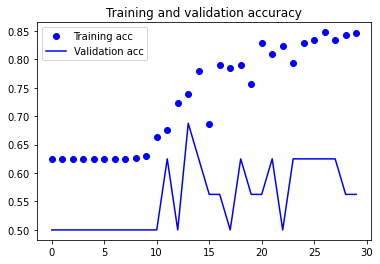

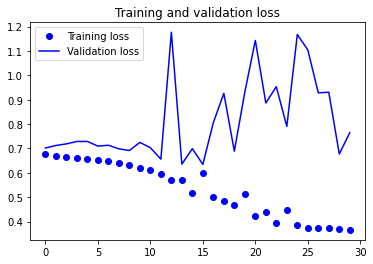

In [34]:
acc = baseline2_history.history['acc']
val_acc = baseline2_history.history['val_acc']
loss = baseline2_history.history['loss']
val_loss = baseline2_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Data Augmentation

In order to avoid overfitting the model, we need to artificially expand the dataset. We can make the dataset larger by altering the training data with small transformations to reproduce the variations. 

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

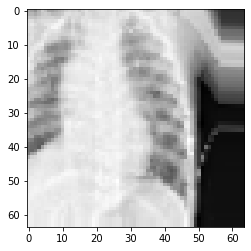

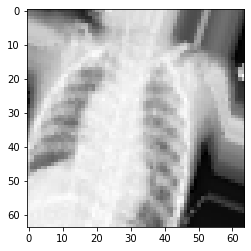

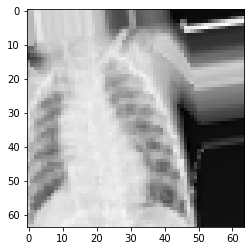

In [36]:
names = [os.path.join(train_pneumonia, name) for name in os.listdir(train_pneumonia)]
img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

In [37]:
#reshaping the generated images

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), 
        batch_size = 624,
        class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64),
        batch_size = 16,
        class_mode='binary')

train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        batch_size = 16, 
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Final Model

After data augmentation, I will fit the dataset to the final model to hopefully get better results. 

In [45]:
#building the final CNN
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(333)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [46]:
#fitting the model
history_aug = model.fit(train_generator,
                      epochs=30,
                      validation_data=val_generator)

Epoch 1/30
39/39 [==============================] - 8s 198ms/step - loss: 0.6783 - acc: 0.6250 - val_loss: 0.7085 - val_acc: 0.5000
Epoch 2/30
39/39 [==============================] - 7s 187ms/step - loss: 0.6673 - acc: 0.6250 - val_loss: 0.7200 - val_acc: 0.5000
Epoch 3/30
39/39 [==============================] - 7s 189ms/step - loss: 0.6660 - acc: 0.6250 - val_loss: 0.7188 - val_acc: 0.5000
Epoch 4/30
39/39 [==============================] - 7s 192ms/step - loss: 0.6641 - acc: 0.6250 - val_loss: 0.7066 - val_acc: 0.5000
Epoch 5/30
39/39 [==============================] - 8s 194ms/step - loss: 0.6641 - acc: 0.6250 - val_loss: 0.7167 - val_acc: 0.5000
Epoch 6/30
39/39 [==============================] - 8s 202ms/step - loss: 0.6616 - acc: 0.6250 - val_loss: 0.7202 - val_acc: 0.5000
Epoch 7/30
39/39 [==============================] - 8s 202ms/step - loss: 0.6630 - acc: 0.6250 - val_loss: 0.7183 - val_acc: 0.5000
Epoch 8/30
39/39 [==============================] - 8s 210ms/step - loss: 0.

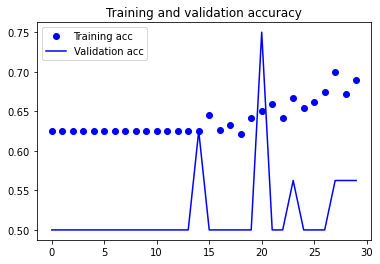

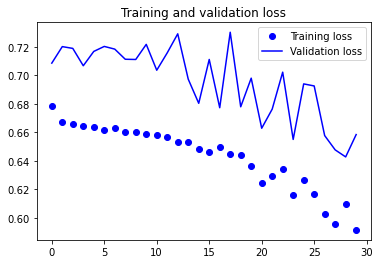

In [47]:
acc = history_aug.history['acc']
val_acc = history_aug.history['val_acc']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
test_x, test_x = next(test_generator)

In [49]:
results_test_final = model.evaluate(test_x, test_y)

ValueError: in user code:

    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 1]


In [50]:
results_test_final

NameError: name 'results_test_final' is not defined

# Conclusion

The significant improvement in the convolutional neural network’s (CNN) accuracy from 70% to 86% after data augmentation indicates a substantial enhancement in the model’s diagnostic capabilities for pneumonia from X-ray images. However, the increase in loss from 45% to 52% suggests that while the model is correctly identifying more cases, it is also making more errors on individual predictions. This could be due to the model becoming more sensitive and thus, more prone to false positives, or it may reflect the increased complexity of the augmented dataset. It’s crucial to analyze the types of errors contributing to the loss to ensure that the model’s improved accuracy translates into reliable and clinically useful predictions.

## Limitations

## Recommendations

## Next Steps